In [3]:
import copy

import pandas as pd

import tarfile


import os
import urllib

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F


from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [4]:
cd '/content/drive/MyDrive/Colab Notebooks/Работа/'

/content/drive/MyDrive/Colab Notebooks/Работа


In [5]:
from DataLoader import *
from Train_process import  *
from Dropaut_Resnet import *
from Contextual_Resnet import *
from utils import *

#Загрузим данные и разместим на диске:

In [ ]:
! wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz

--2021-04-18 00:16:24--  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.132.24
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.132.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328387740 (313M) [application/x-tar]
Saving to: ‘imagewoof2-320.tgz.2’

imagewoof2-320.tgz.  30%[=====>              ]  96.11M  30.1MB/s    eta 7s     ^C


In [ ]:
tar = tarfile.open("imagewoof2-320.tgz")
tar.extractall()
tar.close()

KeyboardInterrupt: ignored

# Загрузим файлы

In [6]:
DEVICE = torch.device("cuda")

In [7]:
TEST_DIR = Path('imagewoof2-320/val')
TRAIN_DIR = Path('imagewoof2-320/train')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.JPEG')))
test_files = sorted(list(TEST_DIR.rglob('*.JPEG')))

In [8]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
val_dataset = MyDataset(val_files, mode='val')

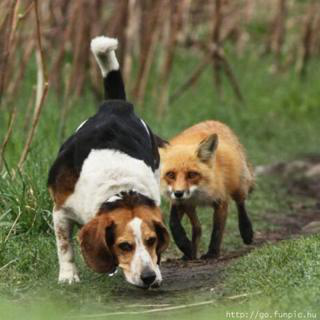

In [10]:
val_dataset.load_sample(val_files[0])

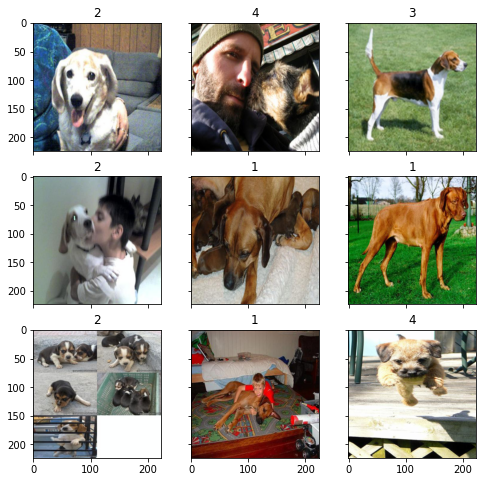

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    imshow(im_val.data.cpu(), \
          title=label,plt_ax=fig_x)

In [12]:
DEVICE = torch.device("cuda")
# DEVICE = torch.device("cpu")

In [13]:
if val_dataset is None:
    val_dataset = MyDataset(val_files, mode='val')
    
train_dataset = MyDataset(train_files, mode='train')

# ResNet без Dropout:

In [ ]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)


for param in model.parameters():
    param.requires_grad = False


num_features = 512

n_classes = len(np.unique(train_val_labels))
model.fc = nn.Linear(num_features, n_classes)

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=64, DEVICE=DEVICE)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.8849026092259878


epoch:  10%|█         | 1/10 [1:04:48<9:43:14, 3888.27s/it]


Epoch 001 train_loss: 0.8849     val_loss 0.4174 train_acc 0.7810 val_acc 0.8906
loss 0.3371642269986741


epoch:  20%|██        | 2/10 [1:06:01<6:05:49, 2743.70s/it]


Epoch 002 train_loss: 0.3372     val_loss 0.3237 train_acc 0.9125 val_acc 0.9012
loss 0.27219327695967177


epoch:  30%|███       | 3/10 [1:07:14<3:46:37, 1942.44s/it]


Epoch 003 train_loss: 0.2722     val_loss 0.2886 train_acc 0.9251 val_acc 0.9074
loss 0.2392972127201991


epoch:  40%|████      | 4/10 [1:08:26<2:18:09, 1381.50s/it]


Epoch 004 train_loss: 0.2393     val_loss 0.2750 train_acc 0.9345 val_acc 0.9096
loss 0.21487785192387043


epoch:  50%|█████     | 5/10 [1:09:39<1:22:24, 988.80s/it]


Epoch 005 train_loss: 0.2149     val_loss 0.2673 train_acc 0.9393 val_acc 0.9105
loss 0.19907239308453056


epoch:  60%|██████    | 6/10 [1:10:51<47:35, 713.94s/it]


Epoch 006 train_loss: 0.1991     val_loss 0.2616 train_acc 0.9447 val_acc 0.9096
loss 0.18690082909931247


epoch:  70%|███████   | 7/10 [1:12:04<26:05, 521.67s/it]


Epoch 007 train_loss: 0.1869     val_loss 0.2559 train_acc 0.9486 val_acc 0.9136
loss 0.17719611416330855


epoch:  80%|████████  | 8/10 [1:13:17<12:54, 387.04s/it]


Epoch 008 train_loss: 0.1772     val_loss 0.2601 train_acc 0.9493 val_acc 0.9070
loss 0.16955447514006433


epoch:  90%|█████████ | 9/10 [1:14:30<04:52, 292.64s/it]


Epoch 009 train_loss: 0.1696     val_loss 0.2572 train_acc 0.9518 val_acc 0.9052
loss 0.16025717910511275


epoch: 100%|██████████| 10/10 [1:15:42<00:00, 454.24s/it]


Epoch 010 train_loss: 0.1603     val_loss 0.2560 train_acc 0.9580 val_acc 0.9123


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plot_res(loss, val_loss, acc)

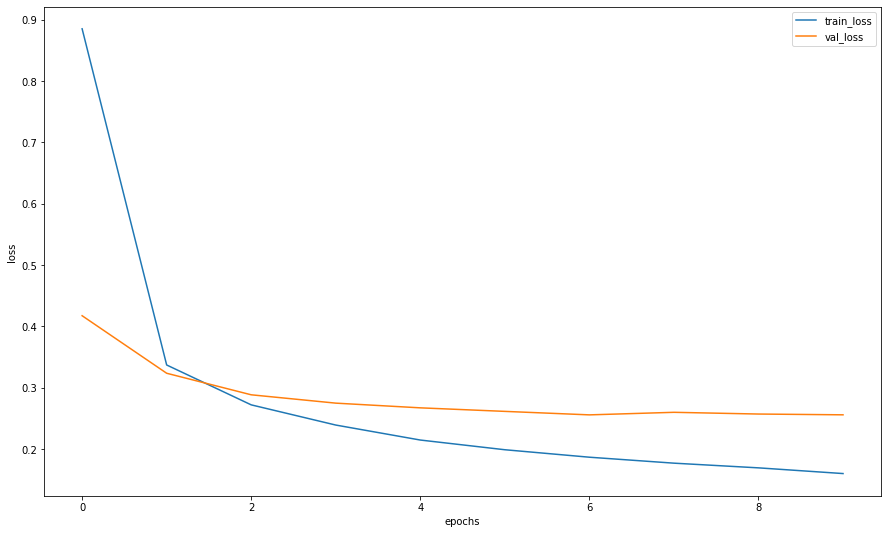

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

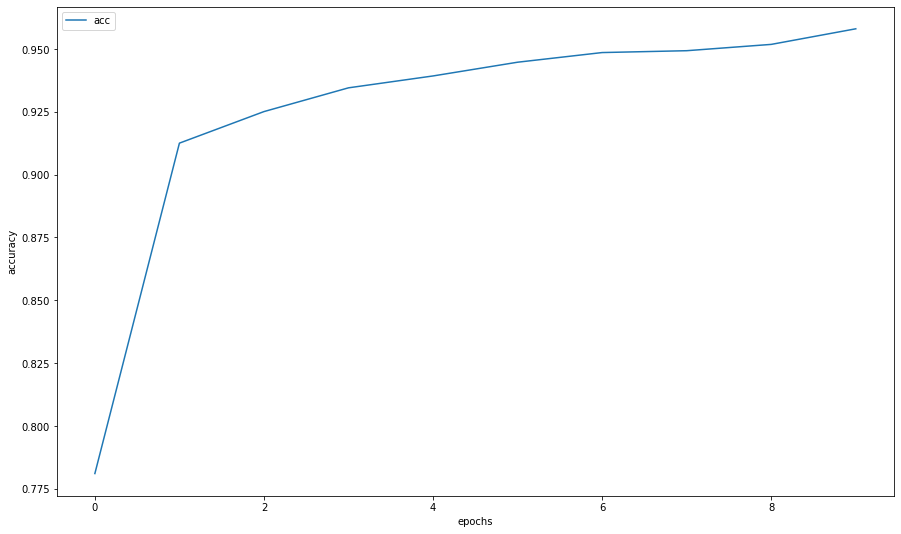

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
calc_metrics(model, DEVICE = DEVICE, el_num = 400,cert_lev = 0.9)

Top1 acc: 0.8975
Multi-lable F1_score: [0.88095238 0.92307692 0.87619048 0.76923077 0.92307692 0.92436975
 0.88172043 0.95454545 0.93333333 0.        ]
PAvPU:0.8475


'done'

In [ ]:
save_model(model, name = 'ResNet_no_drop')

'saved'

# Dropaut model:

In [ ]:
model = ResNet_DropOut()

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet_DropOut(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer11): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop11): Dropout2d(p=0.5, inplace=False)
  (layer12): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReL

In [ ]:
model.to(DEVICE)

ResNet_DropOut(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer11): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop11): Dropout2d(p=0.5, inplace=False)
  (layer12): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReL

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=64, DEVICE=DEVICE)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.7009084091541615


epoch:  10%|█         | 1/10 [44:19<6:38:52, 2659.17s/it]


Epoch 001 train_loss: 0.7009     val_loss 0.3233 train_acc 0.8273 val_acc 0.9136
loss 0.26058192350340226


epoch:  20%|██        | 2/10 [45:37<4:11:19, 1884.92s/it]


Epoch 002 train_loss: 0.2606     val_loss 0.2560 train_acc 0.9286 val_acc 0.9220
loss 0.2129300278974763


epoch:  30%|███       | 3/10 [46:55<2:36:40, 1342.88s/it]


Epoch 003 train_loss: 0.2129     val_loss 0.2352 train_acc 0.9353 val_acc 0.9273
loss 0.18747325009065316


epoch:  40%|████      | 4/10 [48:16<1:36:26, 964.33s/it]


Epoch 004 train_loss: 0.1875     val_loss 0.2239 train_acc 0.9444 val_acc 0.9287
loss 0.1715289973796964


epoch:  50%|█████     | 5/10 [49:35<58:14, 698.81s/it]


Epoch 005 train_loss: 0.1715     val_loss 0.2204 train_acc 0.9483 val_acc 0.9313
loss 0.16185479059850635


epoch:  60%|██████    | 6/10 [50:51<34:07, 511.87s/it]


Epoch 006 train_loss: 0.1619     val_loss 0.2218 train_acc 0.9492 val_acc 0.9251
loss 0.1505054039242138


epoch:  70%|███████   | 7/10 [52:07<19:03, 381.15s/it]


Epoch 007 train_loss: 0.1505     val_loss 0.2136 train_acc 0.9554 val_acc 0.9300
loss 0.14263414598596294


epoch:  80%|████████  | 8/10 [53:23<09:38, 289.45s/it]


Epoch 008 train_loss: 0.1426     val_loss 0.2132 train_acc 0.9567 val_acc 0.9340
loss 0.13560917156244282


epoch:  90%|█████████ | 9/10 [54:39<03:45, 225.60s/it]


Epoch 009 train_loss: 0.1356     val_loss 0.2128 train_acc 0.9589 val_acc 0.9318
loss 0.13027764606701284


epoch: 100%|██████████| 10/10 [55:57<00:00, 335.74s/it]


Epoch 010 train_loss: 0.1303     val_loss 0.2103 train_acc 0.9594 val_acc 0.9349


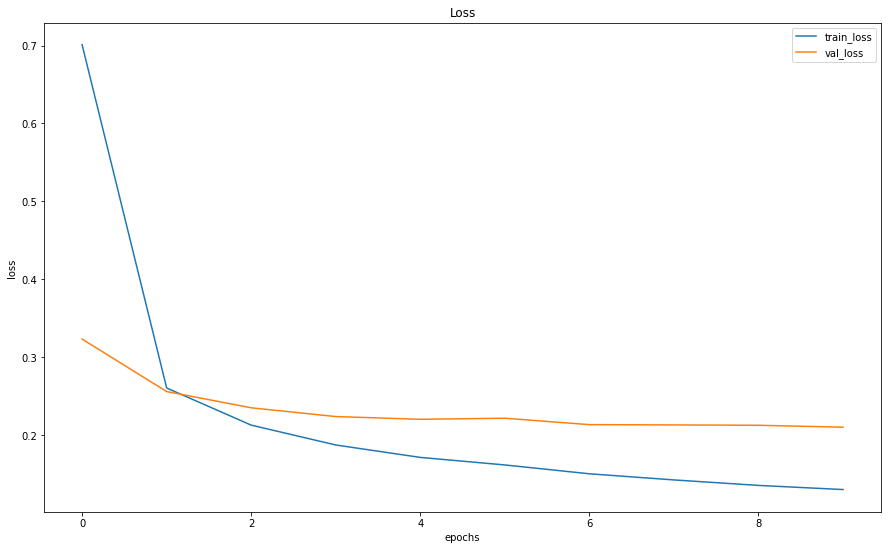

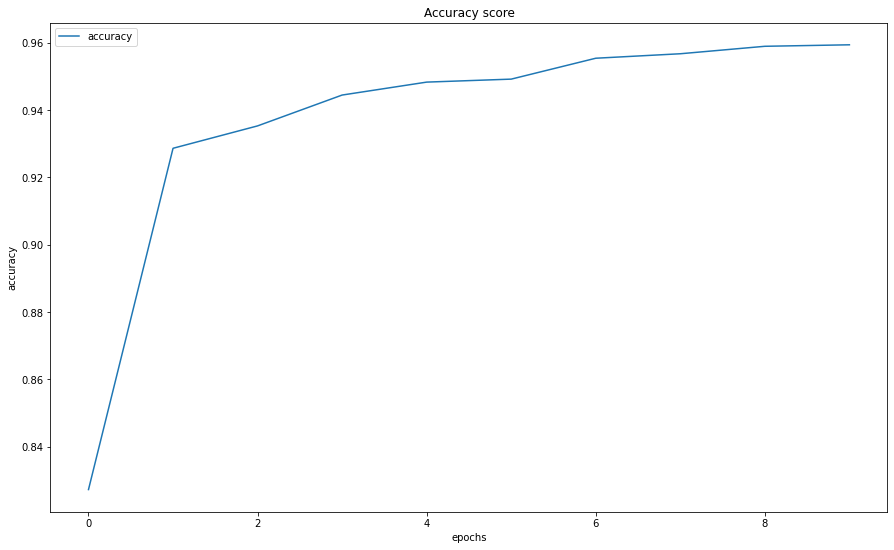

0

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plot_res(loss, val_loss, acc)

In [15]:
calc_metrics(model,val_dataset, DEVICE = DEVICE, el_num = 400,cert_lev = 0.9)

Top1 acc: 0.96
Multi-lable F1_score: [0.93069307 0.98901099 0.9382716  0.90909091 0.96491228 0.94871795
 0.97916667 0.98076923 0.975     ]
PAvPU:0.8675


'done'

In [ ]:
save_model(model, name = 'ResNet_dropout')

'saved'

In [14]:
model = load_model(name = 'ResNet_dropout')
# print(DEVICE)
# calc_metrics(model,val_dataset, DEVICE = DEVICE, el_num = 400,cert_lev = 0.9)

# Contextual dropaut


In [ ]:
torch.pi = torch.acos(torch.zeros(1)).item() * 2

In [ ]:
model =  ResNet_Contextual_DropOut()
model

ResNet_Contextual_DropOut(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer11): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop11): Context_Dropout(
    (enc_lay): Encoderblock(
      (avg1): AvgPool2d(kernel_size=(56, 56), stride=(56, 56), padding=0)
      (lin1): Linear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
      (lin2): Linear(in_features=64, 

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=64, DEVICE=DEVICE)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plot_res(loss, val_loss, acc)

In [ ]:
calc_metrics(model, DEVICE = 'cpu', el_num = 400,cert_lev = 0.9)

In [ ]:
save_model(model, name = 'ResNet_dropout')